In [1]:
# Imports
import pandas as pd
from pandas import DataFrame
import numpy as np
import os
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from scipy.stats import skew
from tqdm import tqdm, tqdm_pandas
tqdm_pandas(tqdm())
from collections import Counter
import itertools
import ast
import shifterator as sh
from chart_studio import plotly as py
from wordcloud import WordCloud
import plotly.graph_objs as go
from sklearn.feature_extraction.text import TfidfVectorizer

0it [00:00, ?it/s]


In [4]:
# Customize parameters of the matplotlib library.
def setup_mpl():
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["lines.linewidth"] = 1
setup_mpl()

In [5]:
color_list = ["303638","f0c808","5d4b20","469374","9341b3","e3427d","e68653","ebe0b0","edfbba","ffadad","ffd6a5","fdffb6","caffbf","9bf6ff","a0c4ff","bdb2ff","ffc6ff","fffffc"]
color_list = ["#"+i.lower() for i in color_list]

### Contributions

# **TODO**

### Motivation

##### What is your dataset?
The dataset for this project consist of the corpus containing the parliamentary debates over the time periode of 05-01-2015 to 01-03-2021 in the British Parliament. The dataset is collected from the publicly avaliable debates and metadata provided British government. The original intent was to investigate what effect COVID had in a parliamentary context. Each speech have a marked-up transcript containing comments, like long gaps, applause, interrupts and ect. 

##### Why did you choose this/these particular dataset(s)?

The political system itself is built upon a very complicated system with a lot of different actors that all have their own agendas. A place where key figures of this system clash, discuss their idea and try to enforce their ideology and political beliefs is the Parliament. Therefore this project will try to explore these complex networks of interactions. This will mainly be done through a toolbox consisting of text analysis of the PM's statements in the British Parliament and network analysis.

##### What was your goal for the end user's experience?

# **TODO**

### Basic stats. Let's understand the dataset better

##### Write about your choices in data cleaning and preprocessing

First step is to collect and represent the data in a meaningful datastructure that allows for further analysis. For this project all data is collected in a single Pandas dataframe.

The raw data itself is spread over six subfolder, one for each year. In these folders there are two files for each day. One that contains the transcripts themself and another file that contains the corresponding metadata. Each of these files have a ID column that allows to match the rows of the two data files.

In [ ]:
# Create temp meta dataframe
ParlaMint_meta = pd.DataFrame()
rootdir = 'data/ParlaMint-GB.txt'
for subdir, dirs, files in tqdm(os.walk(rootdir)):
    for file in files:
        filename = os.fsdecode(file)
        if filename.endswith(".tsv"):
            #Create the dataframe for metadata
            temp_meta = pd.read_csv(os.path.join(subdir, file), sep = "\t", header = None, skiprows = 1) # Skip the header row
            ParlaMint_meta = pd.concat([ParlaMint_meta, temp_meta], axis = 0) # concat along columns

In [ ]:
# Create temp text dataframe
ParlaMint_text = pd.DataFrame()

rootdir = 'data/ParlaMint-GB.txt'
for subdir, dirs, files in tqdm(os.walk(rootdir)):
    for file in files:
        #print(os.fsdecode(file))
        filename = os.fsdecode(file)
        if filename.endswith(".txt"):
            #Create the dataframe for text
            temp_text = pd.read_csv(os.path.join(subdir, file), sep = "\t", header = None)
            ParlaMint_text = pd.concat([ParlaMint_text, temp_text], axis = 0, ignore_index = True) # concat along columns

In [ ]:
# Test relation between the two dataframes to ensure match in index.
idx_1 = ParlaMint_meta.iloc[:, 0].tolist()
idx_2 = ParlaMint_text.iloc[:, 0].tolist()
idx_1 == idx_2

Now the two dataframes are concatenated together with their column names.

In [ ]:
ParlaMint = ParlaMint_meta.copy()
# Add text as new column
ParlaMint["Text"] = ParlaMint_text[1].values
# create rename dict
column_names = ['ID', 'Title', 'From', 'To', 'House', 'Term', 'Session', 'Meeting',
       'Sitting', 'Agenda', 'Subcorpus', 'Speaker_role', 'Speaker_type',
       'Speaker_party', 'Speaker_party_name', 'Party_status', 'Speaker_name',
       'Speaker_gender', 'Speaker_birth', "Text"]
new_column_names = [(i, item) for i, item in enumerate(column_names)]
new_column_names = {key: value for (key, value) in new_column_names}
ParlaMint.rename(columns = new_column_names, inplace = True)

In [ ]:
# Save to csv
ParlaMint.to_csv("data/parlamint.csv")

##### Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)

In the following section a summary of the key values and characteristics are presented. 

First step is to load in the data that was collected in the previous steps.

In [6]:
column_names = ['ID', 'Title', 'From', 'To', 'House', 'Term', 'Session', 'Meeting',
       'Sitting', 'Agenda', 'Subcorpus', 'Speaker_role', 'Speaker_type',
       'Speaker_party', 'Speaker_party_name', 'Party_status', 'Speaker_name',
       'Speaker_gender', 'Speaker_birth', "Text"]
ParlaMint = pd.read_csv("data/parlamint.csv", index_col=False, usecols = column_names)
# Show head of the data
ParlaMint.head()

ID  \
0  ParlaMint-GB_2015-01-05-commons.u1   
1  ParlaMint-GB_2015-01-05-commons.u2   
2  ParlaMint-GB_2015-01-05-commons.u3   
3  ParlaMint-GB_2015-01-05-commons.u4   
4  ParlaMint-GB_2015-01-05-commons.u5   

                                               Title        From          To  \
0  Minutes of the House of Commons, Daily Session...  2015-01-05  2015-01-05   
1  Minutes of the House of Commons, Daily Session...  2015-01-05  2015-01-05   
2  Minutes of the House of Commons, Daily Session...  2015-01-05  2015-01-05   
3  Minutes of the House of Commons, Daily Session...  2015-01-05  2015-01-05   
4  Minutes of the House of Commons, Daily Session...  2015-01-05  2015-01-05   

         House  Term  Session  Meeting  Sitting  Agenda  Subcorpus  \
0  Lower house    55      NaN      NaN      NaN     NaN  Reference   
1  Lower house    55      NaN      NaN      NaN     NaN  Reference   
2  Lower house    55      NaN      NaN      NaN     NaN  Reference   
3  Lower house    55      NaN      NaN      NaN     NaN  Reference   
4  Lower house    55      NaN      NaN      NaN     NaN  Reference   

  Speaker_role Speaker_type Speaker_party Speaker_party_name Party_status  \
0      Regular           MP            LD   Liberal Democrat    Coalition   
1      Regular           MP           CON       Conservative    Coalition   
2      Regular           MP            LD   Liberal Democrat    Coalition   
3      Regular           MP           CON       Conservative    Coalition   
4      Regular           MP           LAB             Labour   Opposition   

              Speaker_name Speaker_gender Speaker_birth  \
0  Willott, Jennifer Nancy              F             -   
1        May, Theresa Mary              F             -   
2  Willott, Jennifer Nancy              F             -   
3        May, Theresa Mary              F             -   
4    Cunningham, Alexander              M             -   

                                                Text  
0  1. What progress her Department has made on im...  
1  The Government are on track to deliver their c...  
2  It is clear that exit checks, which were scrap...  
3  As I indicated in my original answer, we are o...  
4  19. Given the situation at our border in Calai...

Next step is exploration of the size of the dataset

In [5]:
MB_size = os.path.getsize("data/parlamint.csv") / 1024 / 1024 # Convert from byte to MB
print(f"The dataset is {MB_size:0.2f} MB.")
print(f"The dataset consists of {ParlaMint.shape[0]} datapoints each with a feature length of {ParlaMint.shape[1]}.")

The dataset is 676.02 MB.
The dataset consists of 552103 datapoints each with a feature length of 20.


Here each datapoints should be understood as a MP's statement, while the next row in the dataset is the following MP's/speakers statement.

Next step is to explore if there are any redunctant or dirty data that needs to be filter out before further analysis.

In [6]:
ParlaMint.count()

ID                    552103
Title                 552103
From                  552103
To                    552103
House                 552103
Term                  552103
Session                    0
Meeting                    0
Sitting                    0
Agenda                     0
Subcorpus             552103
Speaker_role          552103
Speaker_type          552103
Speaker_party         550489
Speaker_party_name    551961
Party_status          548885
Speaker_name          552103
Speaker_gender        552103
Speaker_birth         552103
Text                  552103
dtype: int64

From the counts of each columns it is seen that the columns Session, Meeting, Sitting , Agenda only contains NaN-values and therefore can be excluded. 

In [8]:
np.unique(ParlaMint["Speaker_birth"].values)

array(['-'], dtype=object)

Here it is seen that the Speaker Birth column only contains "-" and not the actual birthday of the speaker. Therefore this column is also excluded. 

In [9]:
print(ParlaMint["Party_status"][ParlaMint["Party_status"] == "Coalition"])
ParlaMint["From"].iloc[27461]

0        Coalition
1        Coalition
2        Coalition
3        Coalition
5        Coalition
           ...    
27457    Coalition
27458    Coalition
27459    Coalition
27460    Coalition
27461    Coalition
Name: Party_status, Length: 17219, dtype: object


'2015-03-26'

As seen from the above result the lastest statement coming from a member attributed to a member of the coalition is index 27461. This means that the last date a MP is attrubuted to the coalition is the 26-03-2015 and the next 6 years MPs are only noted as Opposition. Therefore this column is also removed.

In [10]:
# Drop columns
ParlaMint.drop(columns = ["Session", "Meeting", "Sitting", "Agenda", "Speaker_birth", "Party_status"], inplace = True)
ParlaMint.head()

ID  \
0  ParlaMint-GB_2015-01-05-commons.u1   
1  ParlaMint-GB_2015-01-05-commons.u2   
2  ParlaMint-GB_2015-01-05-commons.u3   
3  ParlaMint-GB_2015-01-05-commons.u4   
4  ParlaMint-GB_2015-01-05-commons.u5   

                                               Title        From          To  \
0  Minutes of the House of Commons, Daily Session...  2015-01-05  2015-01-05   
1  Minutes of the House of Commons, Daily Session...  2015-01-05  2015-01-05   
2  Minutes of the House of Commons, Daily Session...  2015-01-05  2015-01-05   
3  Minutes of the House of Commons, Daily Session...  2015-01-05  2015-01-05   
4  Minutes of the House of Commons, Daily Session...  2015-01-05  2015-01-05   

         House  Term  Subcorpus Speaker_role Speaker_type Speaker_party  \
0  Lower house    55  Reference      Regular           MP            LD   
1  Lower house    55  Reference      Regular           MP           CON   
2  Lower house    55  Reference      Regular           MP            LD   
3  Lower house    55  Reference      Regular           MP           CON   
4  Lower house    55  Reference      Regular           MP           LAB   

  Speaker_party_name             Speaker_name Speaker_gender  \
0   Liberal Democrat  Willott, Jennifer Nancy              F   
1       Conservative        May, Theresa Mary              F   
2   Liberal Democrat  Willott, Jennifer Nancy              F   
3       Conservative        May, Theresa Mary              F   
4             Labour    Cunningham, Alexander              M   

                                                Text  
0  1. What progress her Department has made on im...  
1  The Government are on track to deliver their c...  
2  It is clear that exit checks, which were scrap...  
3  As I indicated in my original answer, we are o...  
4  19. Given the situation at our border in Calai...

Next step is the found out how many unique speakers and the frequency of how many speeches they make.

In [11]:
len(ParlaMint["Speaker_name"].unique())

1895

The following plot shows the top ten speakers.

In [15]:
fig, ax = plt.subplots(figsize = (18,5), dpi = 1000)
speaker_index = ParlaMint["Speaker_name"].value_counts().iloc[0:10].index.tolist()
speaker_values = ParlaMint["Speaker_name"].value_counts().iloc[0:10].values.tolist()

ax.barh(speaker_index, speaker_values, color = "#a0c4ff")
ax.set_yticks(ticks = range(0, len(speaker_index)), labels = speaker_index, fontsize = 20)
ax.set_xlabel("#Speeches", fontsize = 20)
fig.tight_layout()
fig.canvas.draw()
fig.savefig("top_speakers.png")
plt.show()

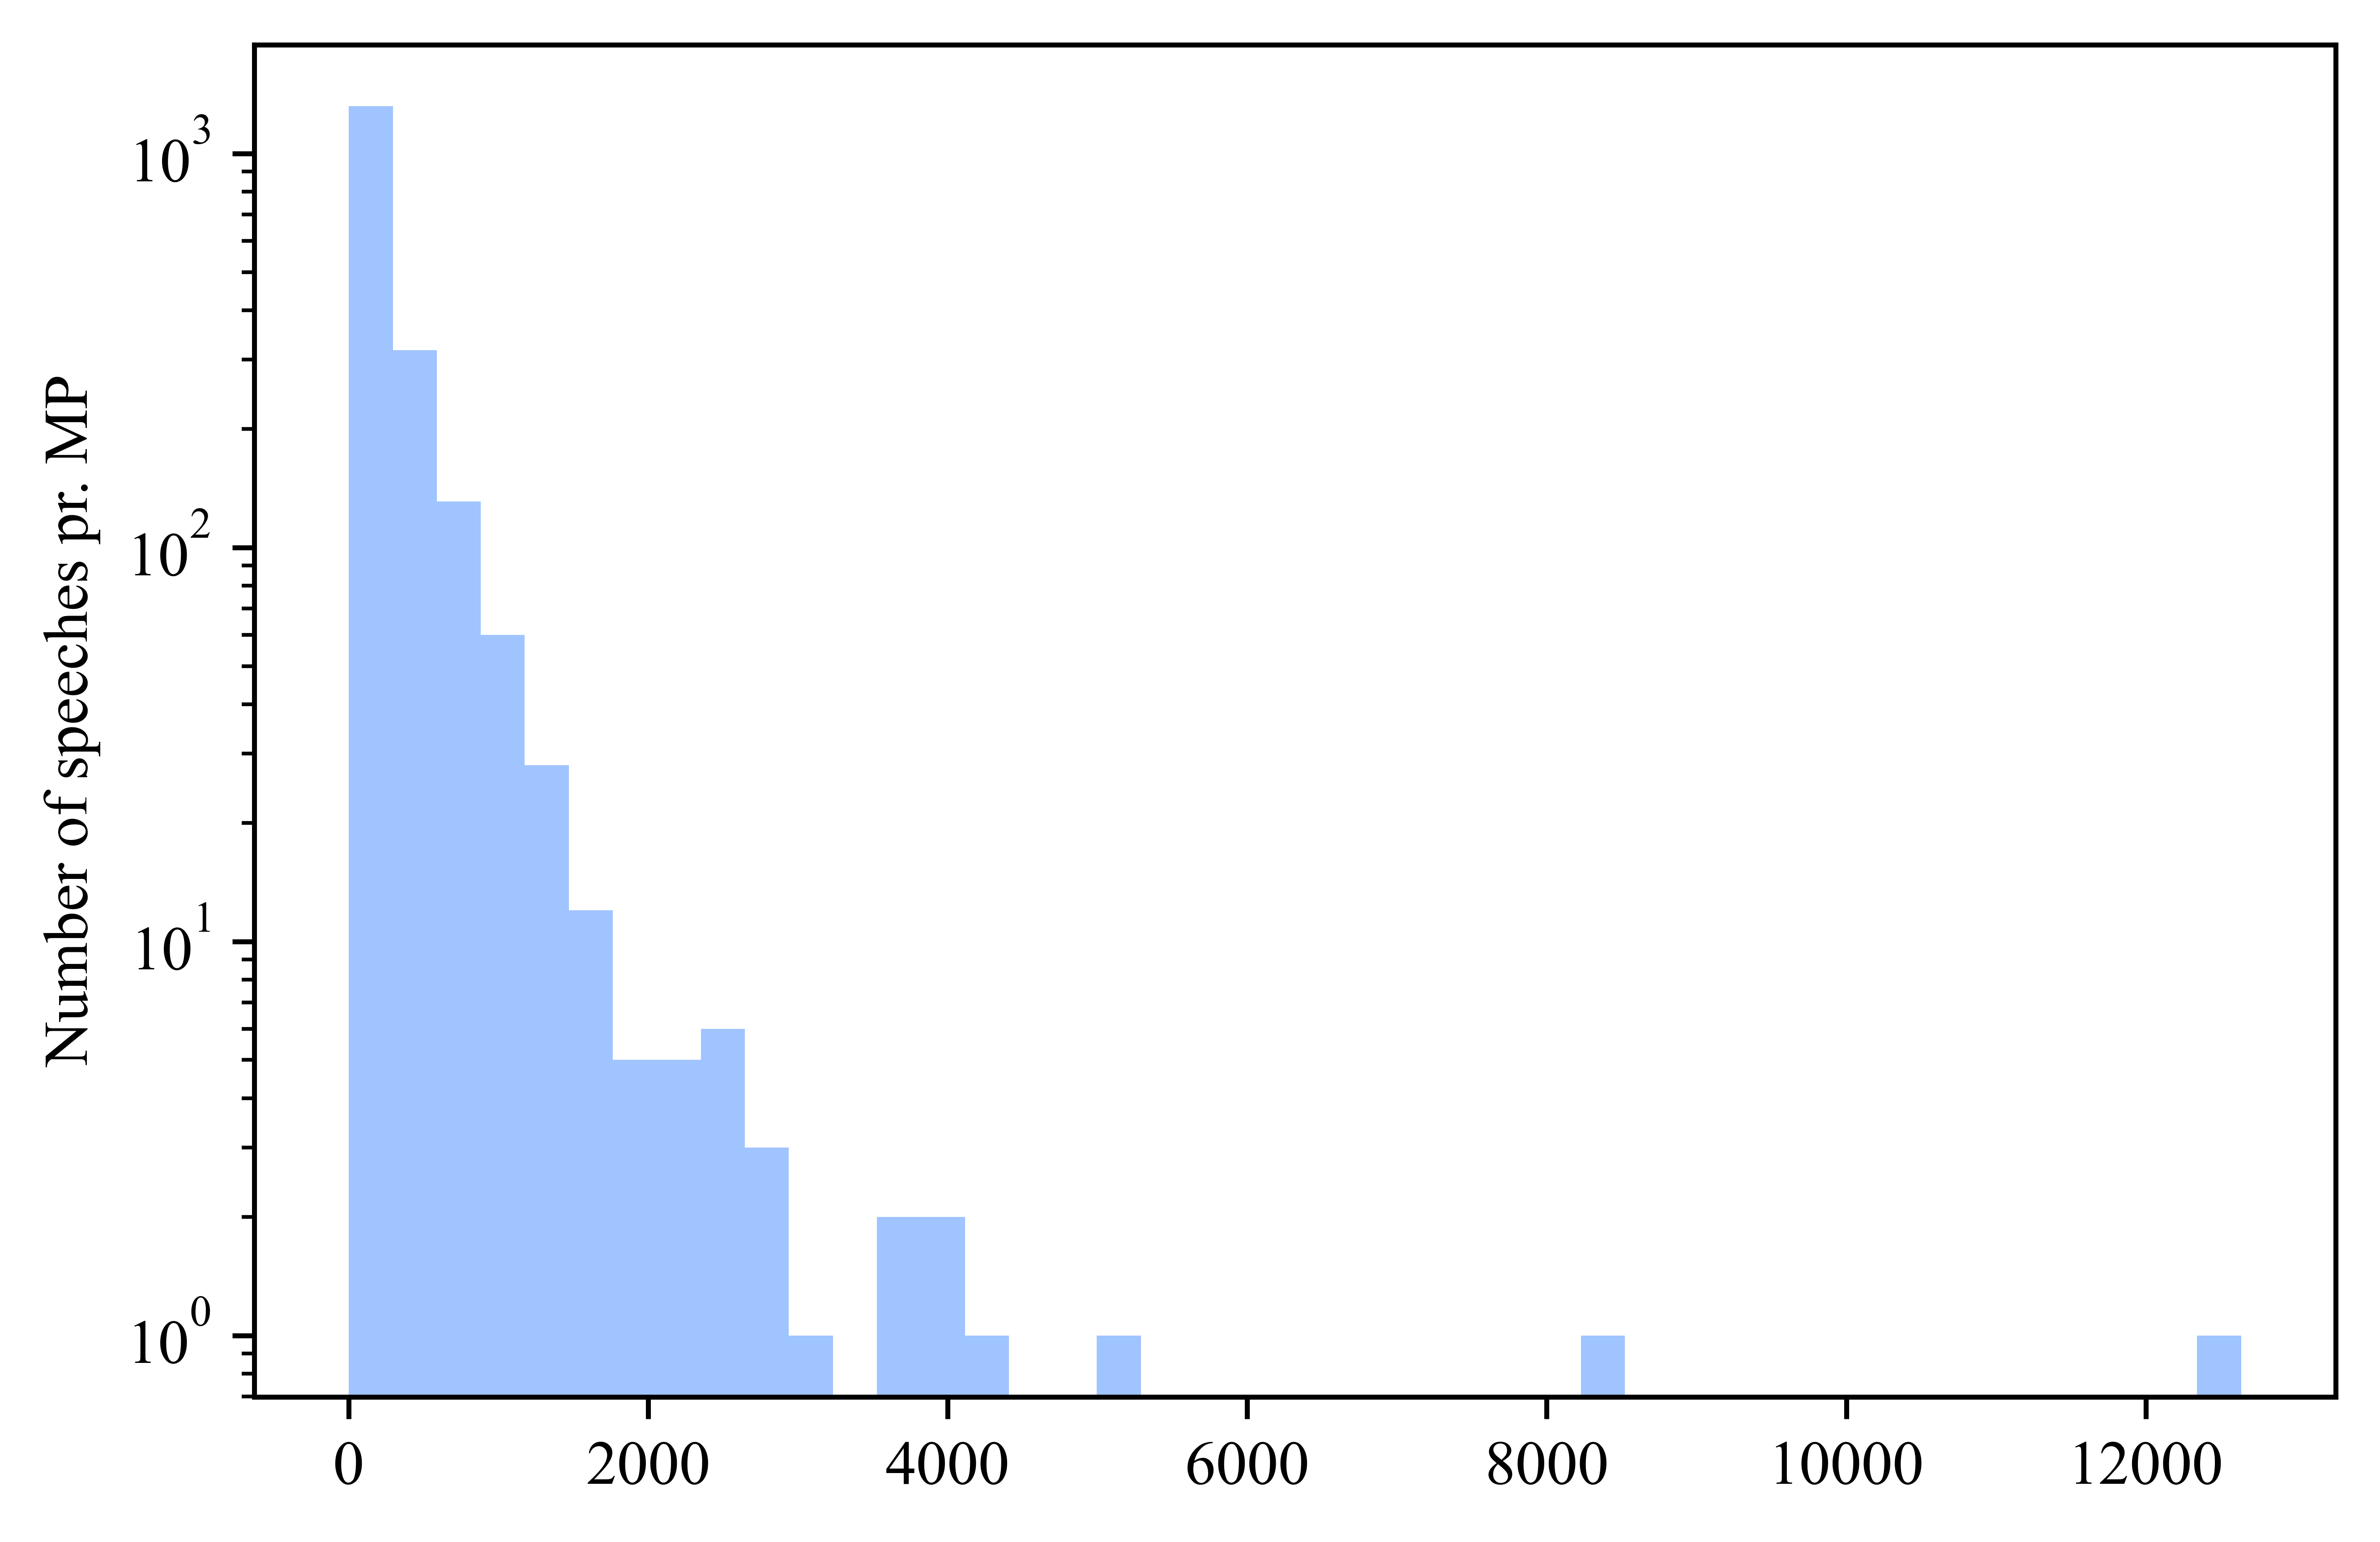

In [16]:
num_speeches = ParlaMint["Speaker_name"].value_counts()
fig, ax = plt.subplots(dpi = 1000)
ax.hist(num_speeches, bins = int(np.sqrt(len(num_speeches))), color = "#a0c4ff")
ax.set_ylabel("Number of speeches pr. MP")
ax.set_yscale("log")
fig.savefig("num_speeches.png")
plt.show()

From this plot it is apparent that the number of addresses each MP makes follows a power law. Prominent politicians are required to be more active in the houses as seen from the top ten speaker that consist of 2 speakers of the house, 2 prime ministers and the rest being ministers. 

Next up is a exploration of the activity in the two houses.

In [17]:
house_df = ParlaMint.groupby(by = ["From", "House"]).count()
house_df = house_df.iloc[:,0]
house_df = house_df.reset_index()
house_df = house_df.rename(columns = {"ID":"Count"})
house_df['From'] = pd.to_datetime(house_df['From'])

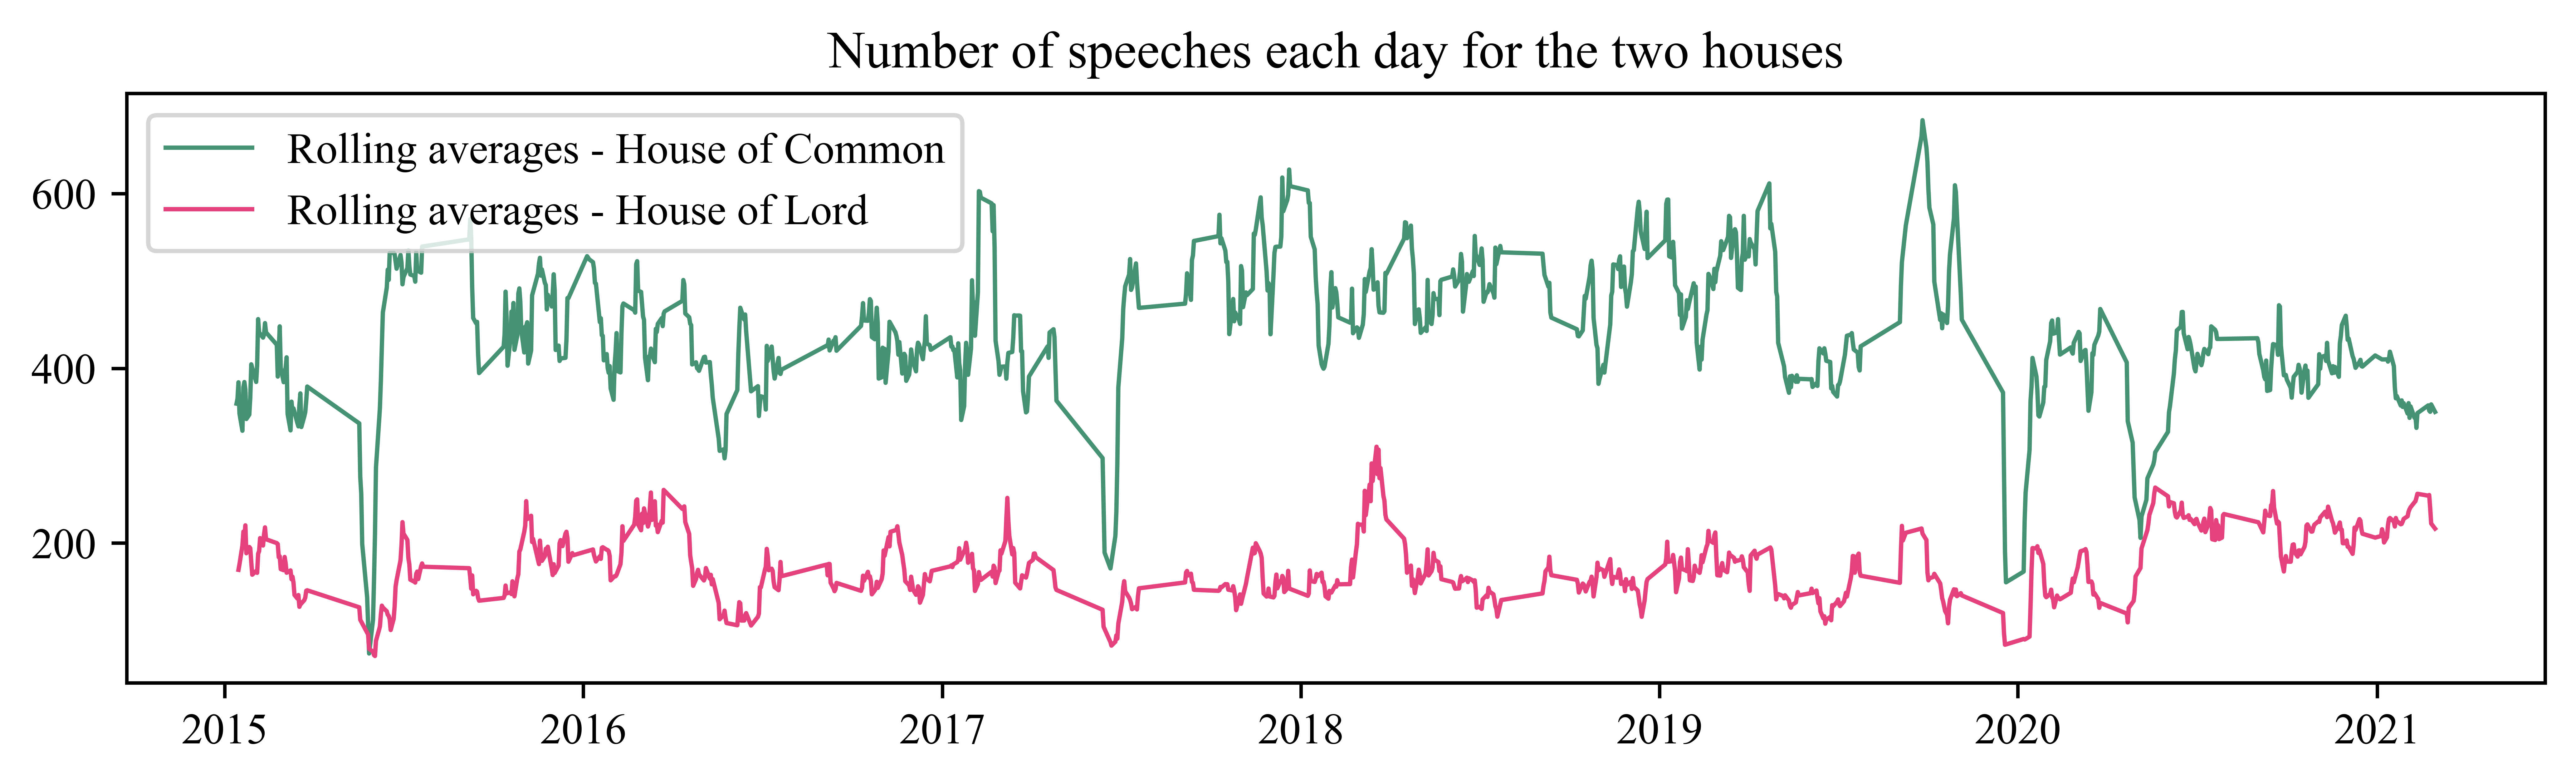

In [22]:
rolling_lower = house_df["Count"][house_df["House"] == "Lower house"].rolling(7).mean()
rolling_upper = house_df["Count"][house_df["House"] == "Upper house"].rolling(7).mean()
myFmt = mdates.DateFormatter("%b %Y")
fig, ax = plt.subplots(figsize=(10,2.5), dpi = 1000)
ax.plot(house_df["From"][house_df["House"] == "Lower house"], rolling_lower, label = "Rolling averages - House of Common", color = color_list[3])
ax.plot(house_df["From"][house_df["House"] == "Upper house"], rolling_upper, label = "Rolling averages - House of Lord", color = color_list[5])
ax.set_title("Number of speeches each day for the two houses")
fig.savefig("house_speeches.png")
ax.legend()
plt.show()

There is a clear distinction in the activity of the two houses. A hypothesis of why is that the house of common is elected each term and the primary goal of this house is to debate political topics and propose new laws. The lords are appointed and their primary goals are shaping laws and challenging the work of the government.  

In [6]:
gender_df = ParlaMint.groupby(by = ["From", "Speaker_gender"]).count()
gender_df = gender_df.iloc[:,0]
gender_df = gender_df.reset_index()
gender_df = gender_df.rename(columns = {"ID":"Count"})
gender_df['From'] = pd.to_datetime(gender_df['From'])

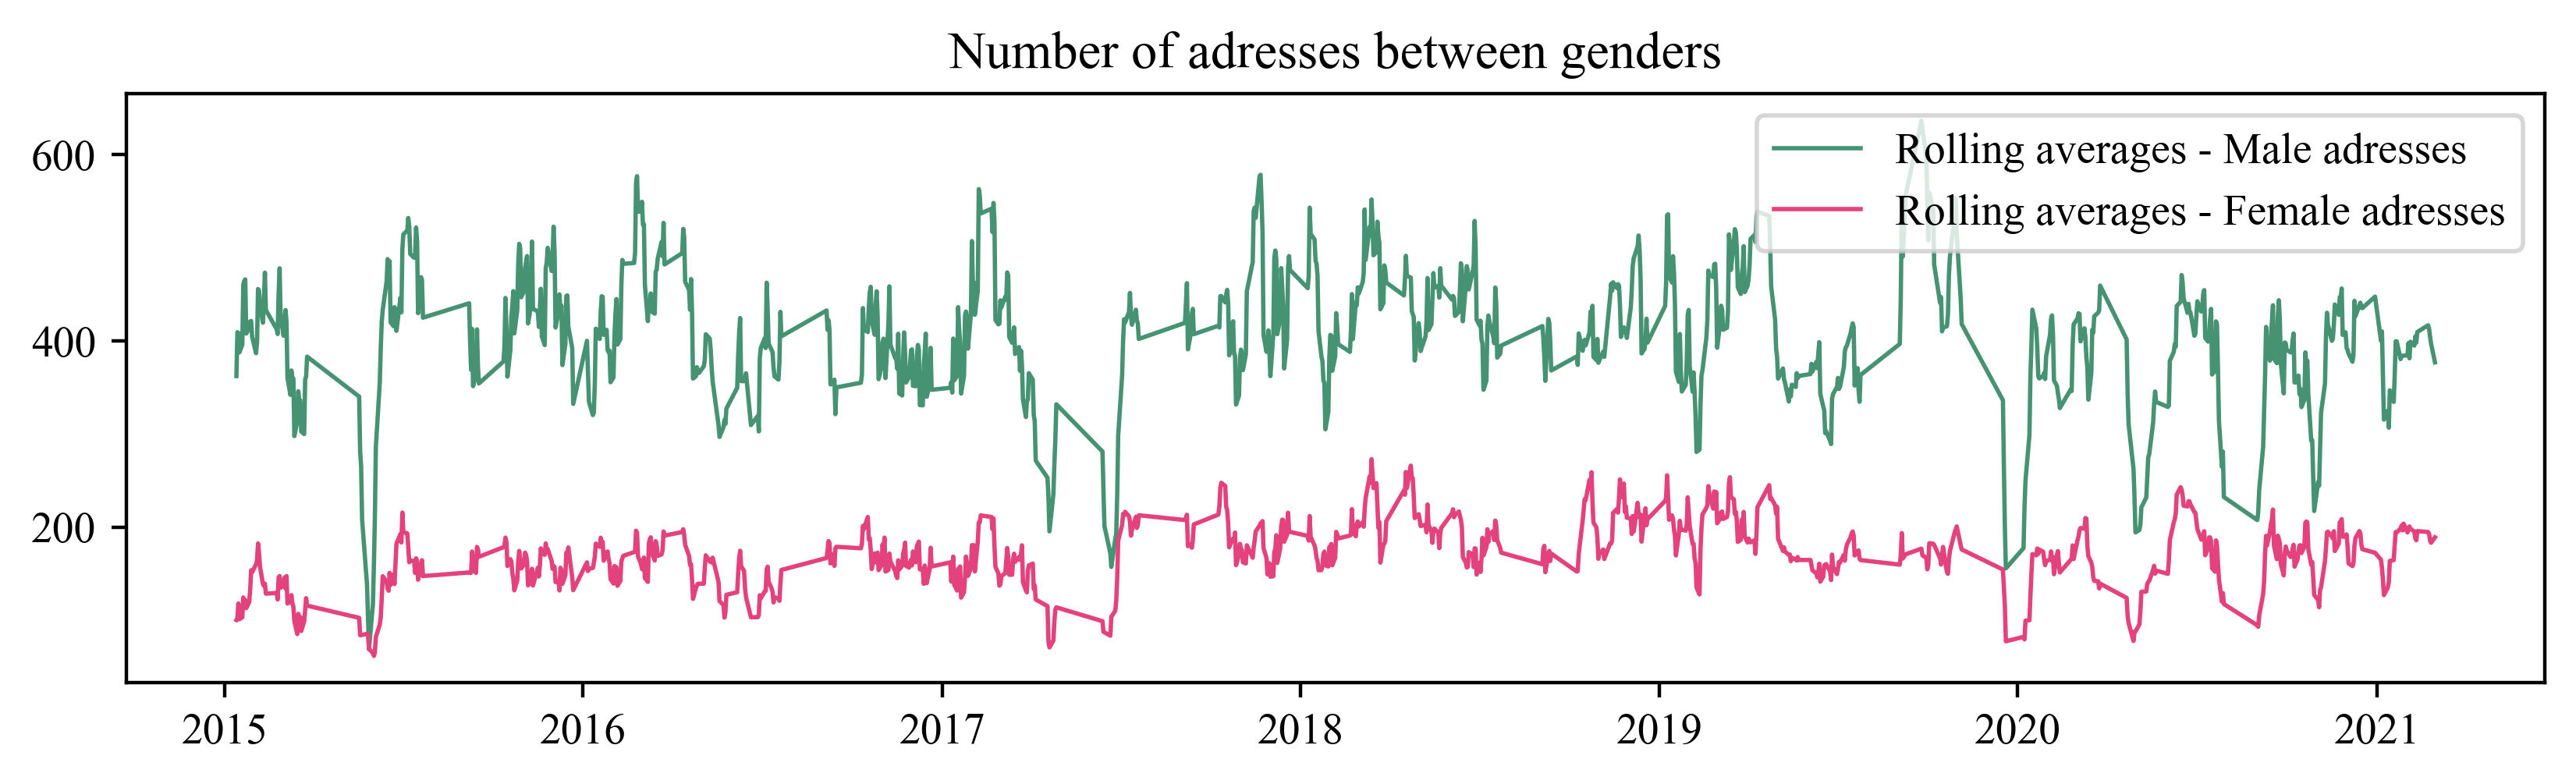

In [7]:
rolling_male = gender_df["Count"][gender_df["Speaker_gender"] == "M"].rolling(7).mean()
rolling_female = gender_df["Count"][gender_df["Speaker_gender"] == "F"].rolling(7).mean()
myFmt = mdates.DateFormatter("%b %Y")
fig, ax = plt.subplots(figsize=(10,2.5), dpi = 400)
ax.plot(gender_df["From"][gender_df["Speaker_gender"] == "M"], rolling_male, label = "Rolling averages - Male adresses", color = color_list[3])
ax.plot(gender_df["From"][gender_df["Speaker_gender"] == "F"], rolling_female, label = "Rolling averages - Female adresses", color = color_list[5])
ax.set_title("Number of adresses between genders")
fig.savefig("gender.png")
ax.legend()
plt.show()

Based exclusively on the number of adresses it seems that the activities in the houses still are highly male dominated. 

### The ten characteristics of big data

After this initial analysis of the data and its structure some of the ten characteristics of big data becomes apparent. In this section some of the most relevant characteristics are explored and used to highlight important distinctive features of the dataset.

* **Dirty:** As previously shown the data contained a "dirty" feature, the "Party_status". This highlight that the dataset is susceptible to being dirty since the data originally is manually collected by the stenographer that afterwards is archived. 
* **Always-on:** Since the British government makes this data publicly available, this project could be updated with the latest debates in the houses. However,  the newer data foundation will have another data structure, so new preprocessing code will have to be delveloped to encompass this. 
* **Incomplete:** As with most datasets, the metadata can always be expanded. In this case, the relation to the topic or bill is missing. Also if the speaker is pro or against the proposed bill. 


### Sentiment analysis

For the basis of the sentiment analysis of the speeches in parliament, a dictionary-based sentiment analysis was applied. Here a predefined dictionary with happiness scores associated with the 10222 most commonly used words in the English dictionary is used to explore if sentiment analysis can highlight any underlying structures of the British parliament.

Firstly the Hedonmeter file containing the happiness scores is loaded in.

In [8]:
# Load in Hedonmeter
labMT = pd.read_csv("../Week_7/Hedonometer.csv")
labMT.head()

Rank       Word Word in English  Happiness Score  \
0     0   laughter        laughter             8.50   
1     1  happiness       happiness             8.44   
2     2       love            love             8.42   
3     3      happy           happy             8.30   
4     4    laughed         laughed             8.26   

   Standard Deviation of Ratings  
0                           0.93  
1                           0.97  
2                           1.11  
3                           0.99  
4                           1.16

To see the distribution of happiness scores a histogram is used.

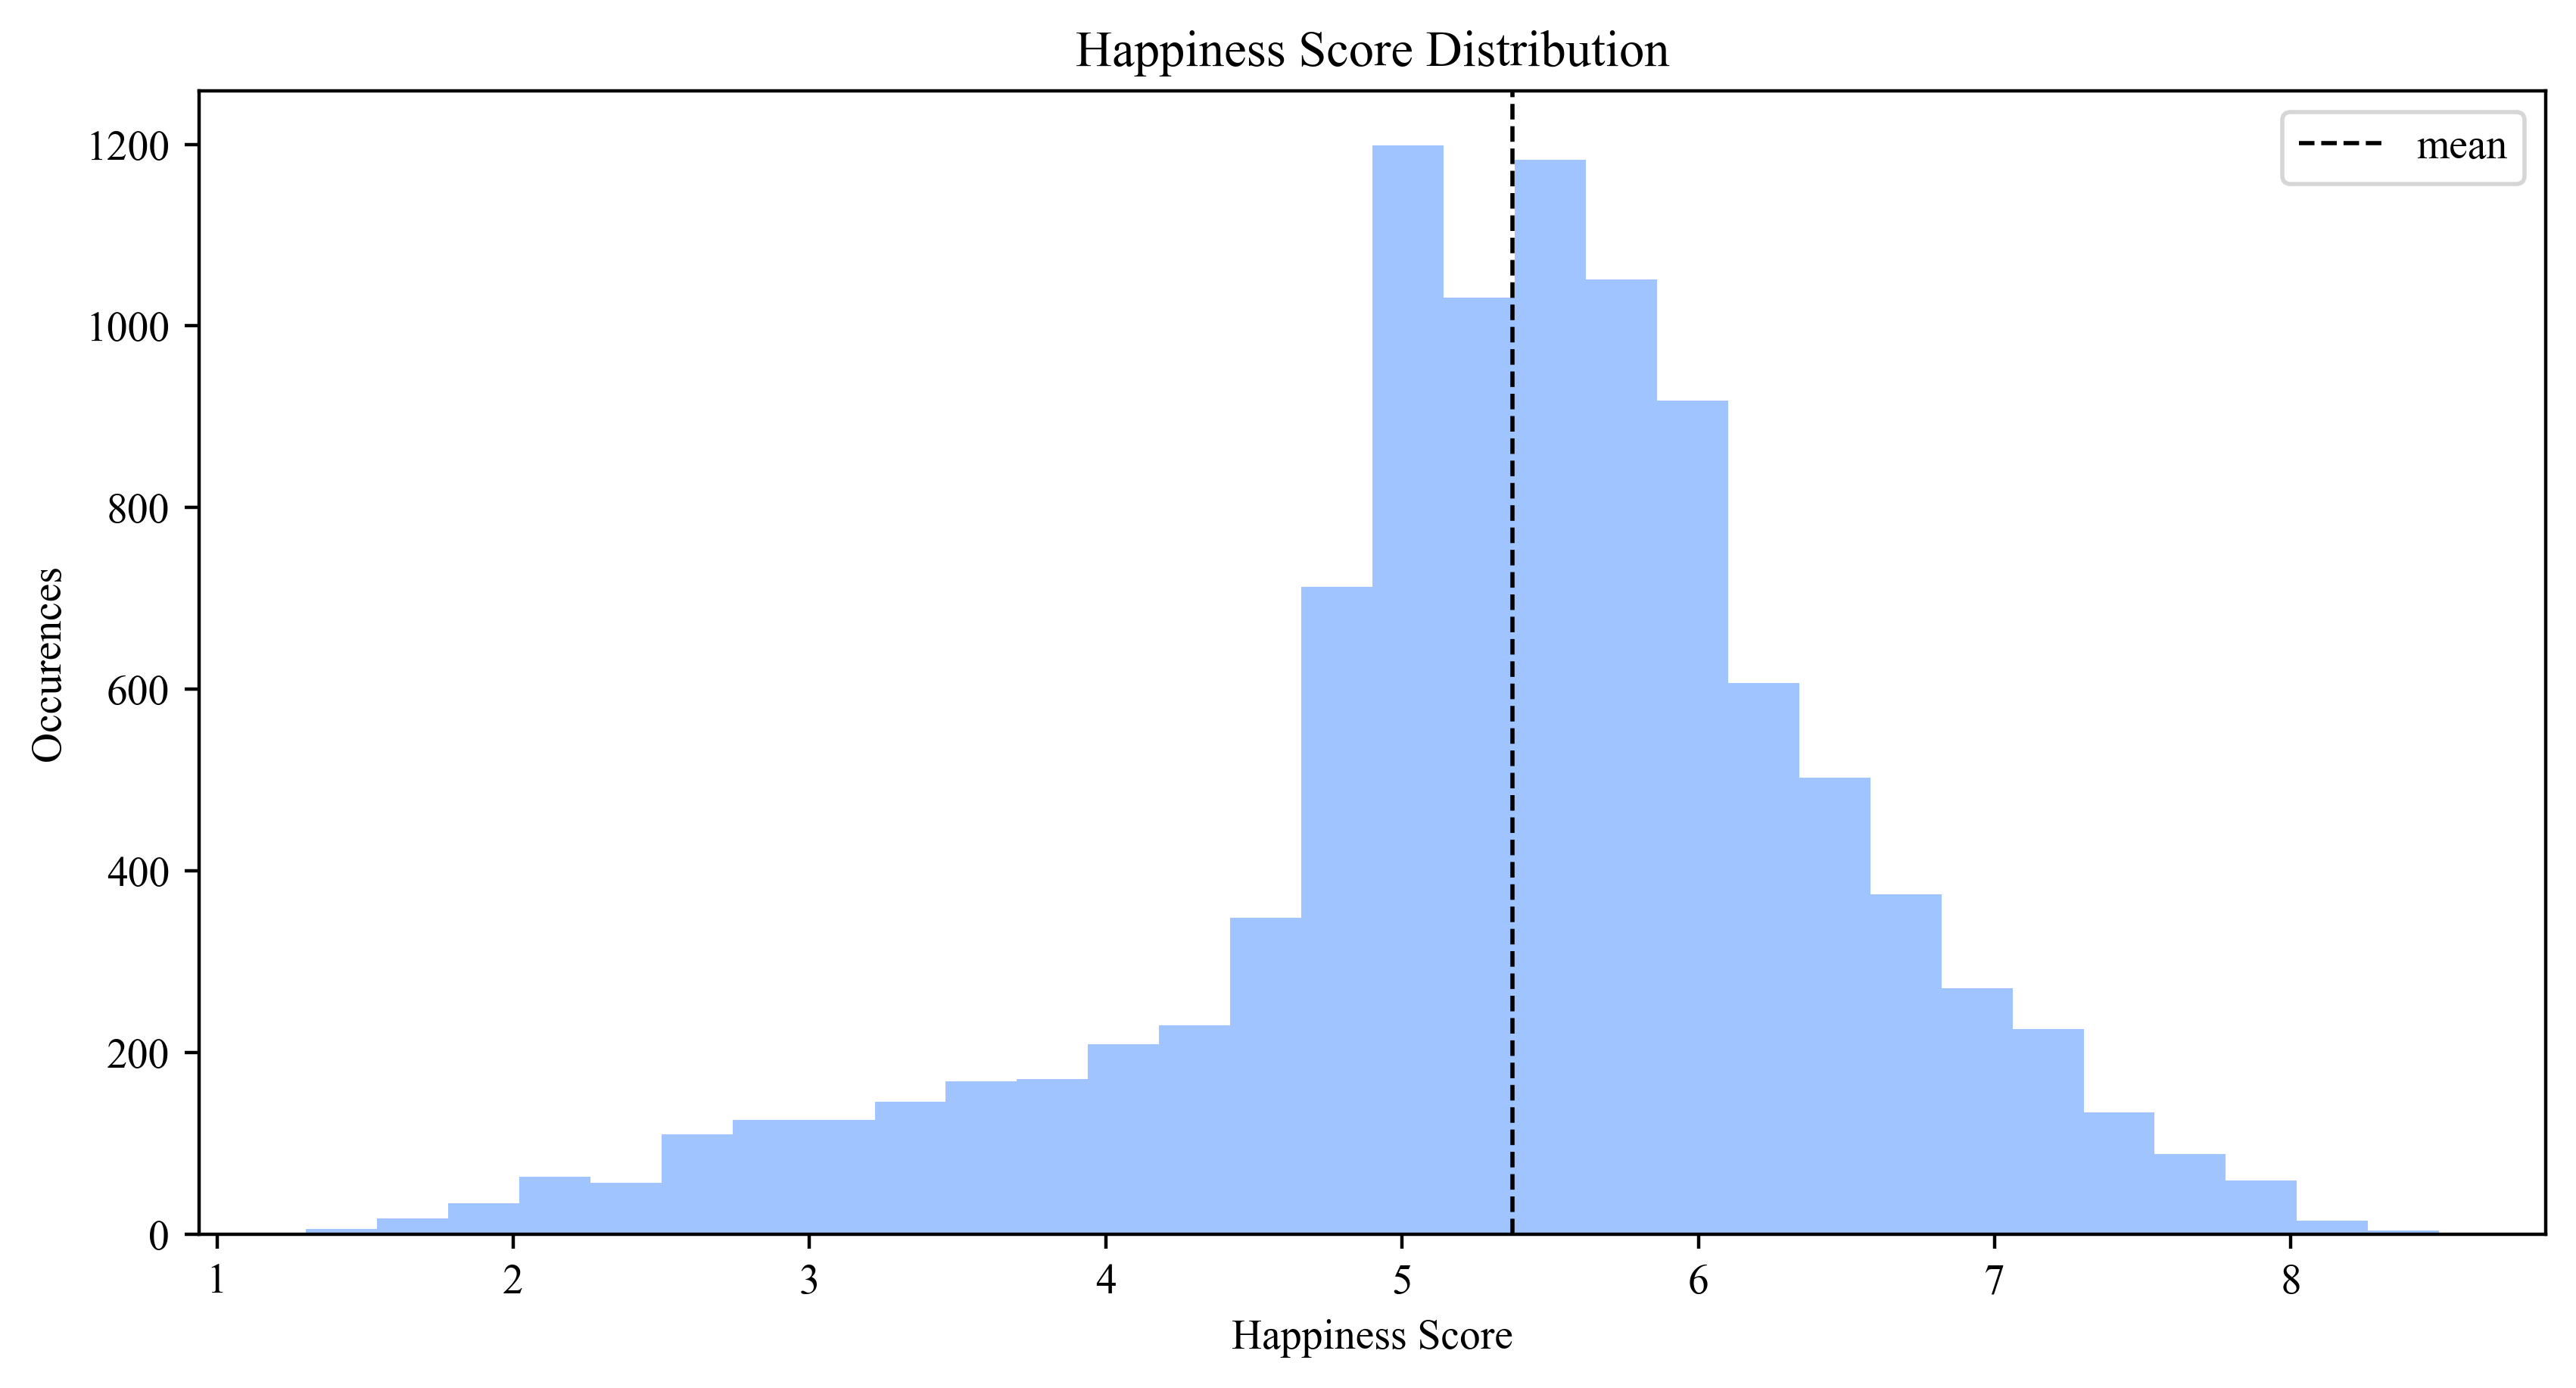

In [10]:
fig, ax = plt.subplots(figsize=(10,5), dpi = 400)
ax.hist(labMT["Happiness Score"].values, bins=30, color = "#a0c4ff")
ax.axvline(labMT["Happiness Score"].mean(), color='k', linestyle='dashed', linewidth=1, label="mean")
ax.set_title("Happiness Score Distribution")
ax.set_xlabel("Happiness Score")
ax.set_ylabel("Occurences")
ax.legend()
plt.show()

In [11]:
print(f'skewness of happiness scores: {skew(labMT["Happiness Score"].values)}')

skewness of happiness scores: -0.6087457806147994


The skewness measure indicate that the distribution have a moderately skewness to it. More specifically it shows that the distribution have a right sided tail. 

Next step is the creation of two function:

The first function *find_the_happiness* is based upon the formula: 
$$h_{avg}(T)=\sum_{i=1}^{N}h_{avg}(w_i)p_i$$
where $p_i = \frac{f_i}{\sum_{j=1}^{N}f_j}$ and $f_i$ is the frequency of the i'th word $w_i$.

The second function *preprocess* takes a text string as input and tokenizes it, filtering out stop words and punctuation. 

In [12]:
def find_the_happiness(tokens, happiness_df):
    # Initialize happiness
    avg_happiness = 0
    tokens = [word.lower() for word in set(tokens) if word.isalpha() and word in labMT["Word"].values]
    fdist = nltk.FreqDist(tokens)
    N = len(tokens)
    for token in tokens:
        p = fdist[token] / N
        avg_happiness += happiness_df['Happiness Score'][happiness_df['Word'] == token].item() * p
    return avg_happiness

def preprocess(text):
    #Common english stop words
    stop_words = set(stopwords.words('english'))
    #Tokenize using nltk
    word_tokens = word_tokenize(text.lower())
    #removing none letter characters and stop words
    filtered_sentence = [word for word in word_tokens if word not in stop_words and word.isalpha()]
    return filtered_sentence

In the following steps the data is tokenized.

In [21]:
ParlaMint["tokens"] = ParlaMint["Text"].progress_apply(lambda x: preprocess(x))

552103it [31:18, 293.87it/s]


In [22]:
# Create new column in datetime.date format based on the "From" column.
ParlaMint["date"] = ParlaMint["From"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").date())

Since the data column describing if each speaker is a member of the coalition or opposition is filtered out the initial sentimental analysis is done on the two major parties from the coalition and the opposition. Namely the Labour party and the Conservative party.

In [23]:
labour_df = ParlaMint[ParlaMint["Speaker_party_name"] == "Labour"]
conservative_df = ParlaMint[ParlaMint["Speaker_party_name"] == "Conservative"]

In [24]:
token_pr_date_labour = labour_df.groupby("date").tokens.sum()
token_pr_date_conservative = conservative_df.groupby("date").tokens.sum()

In [25]:
labour_avg_token = np.mean([len(x) for x in token_pr_date_labour])
conservative_avg_token = np.mean([len(x) for x in token_pr_date_conservative])
print(f"Mean number for token pr date for Labour: {labour_avg_token}")
print(f"Mean number for token pr date for Conservative: {conservative_avg_token}")

Mean number for token pr date for Labour: 13827.087460484721
Mean number for token pr date for Conservative: 25141.098532494758


In [ ]:
token_pr_date_labour = token_pr_date_labour.to_frame()
token_pr_date_conservative = token_pr_date_conservative.to_frame()
token_pr_date_labour.columns = ["document"]
token_pr_date_conservative.columns = ["document"]

In [ ]:
# Now for the happiness
token_pr_date_labour["daily_happiness"] = token_pr_date_labour["document"].progress_apply(lambda x: find_the_happiness(x, labMT))

In [ ]:
token_pr_date_conservative["daily_happiness"] = token_pr_date_conservative["document"].progress_apply(lambda x: find_the_happiness(x, labMT))

Save the previous computations so they don't have to be repeated. 

In [ ]:
token_pr_date_labour.to_csv("data/token_pr_date_labour.csv")
token_pr_date_conservative.to_csv("data/token_pr_date_conservative.csv")

Load in the data if stored.

In [28]:
token_pr_date_labour = pd.read_csv("data/token_pr_date_labour.csv")
token_pr_date_conservative = pd.read_csv("data/token_pr_date_conservative.csv")
token_pr_date_labour["date"] = token_pr_date_labour["date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").date())
token_pr_date_conservative["date"] = token_pr_date_conservative["date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").date())
token_pr_date_labour.set_index("date", inplace = True)
token_pr_date_conservative.set_index("date", inplace = True)

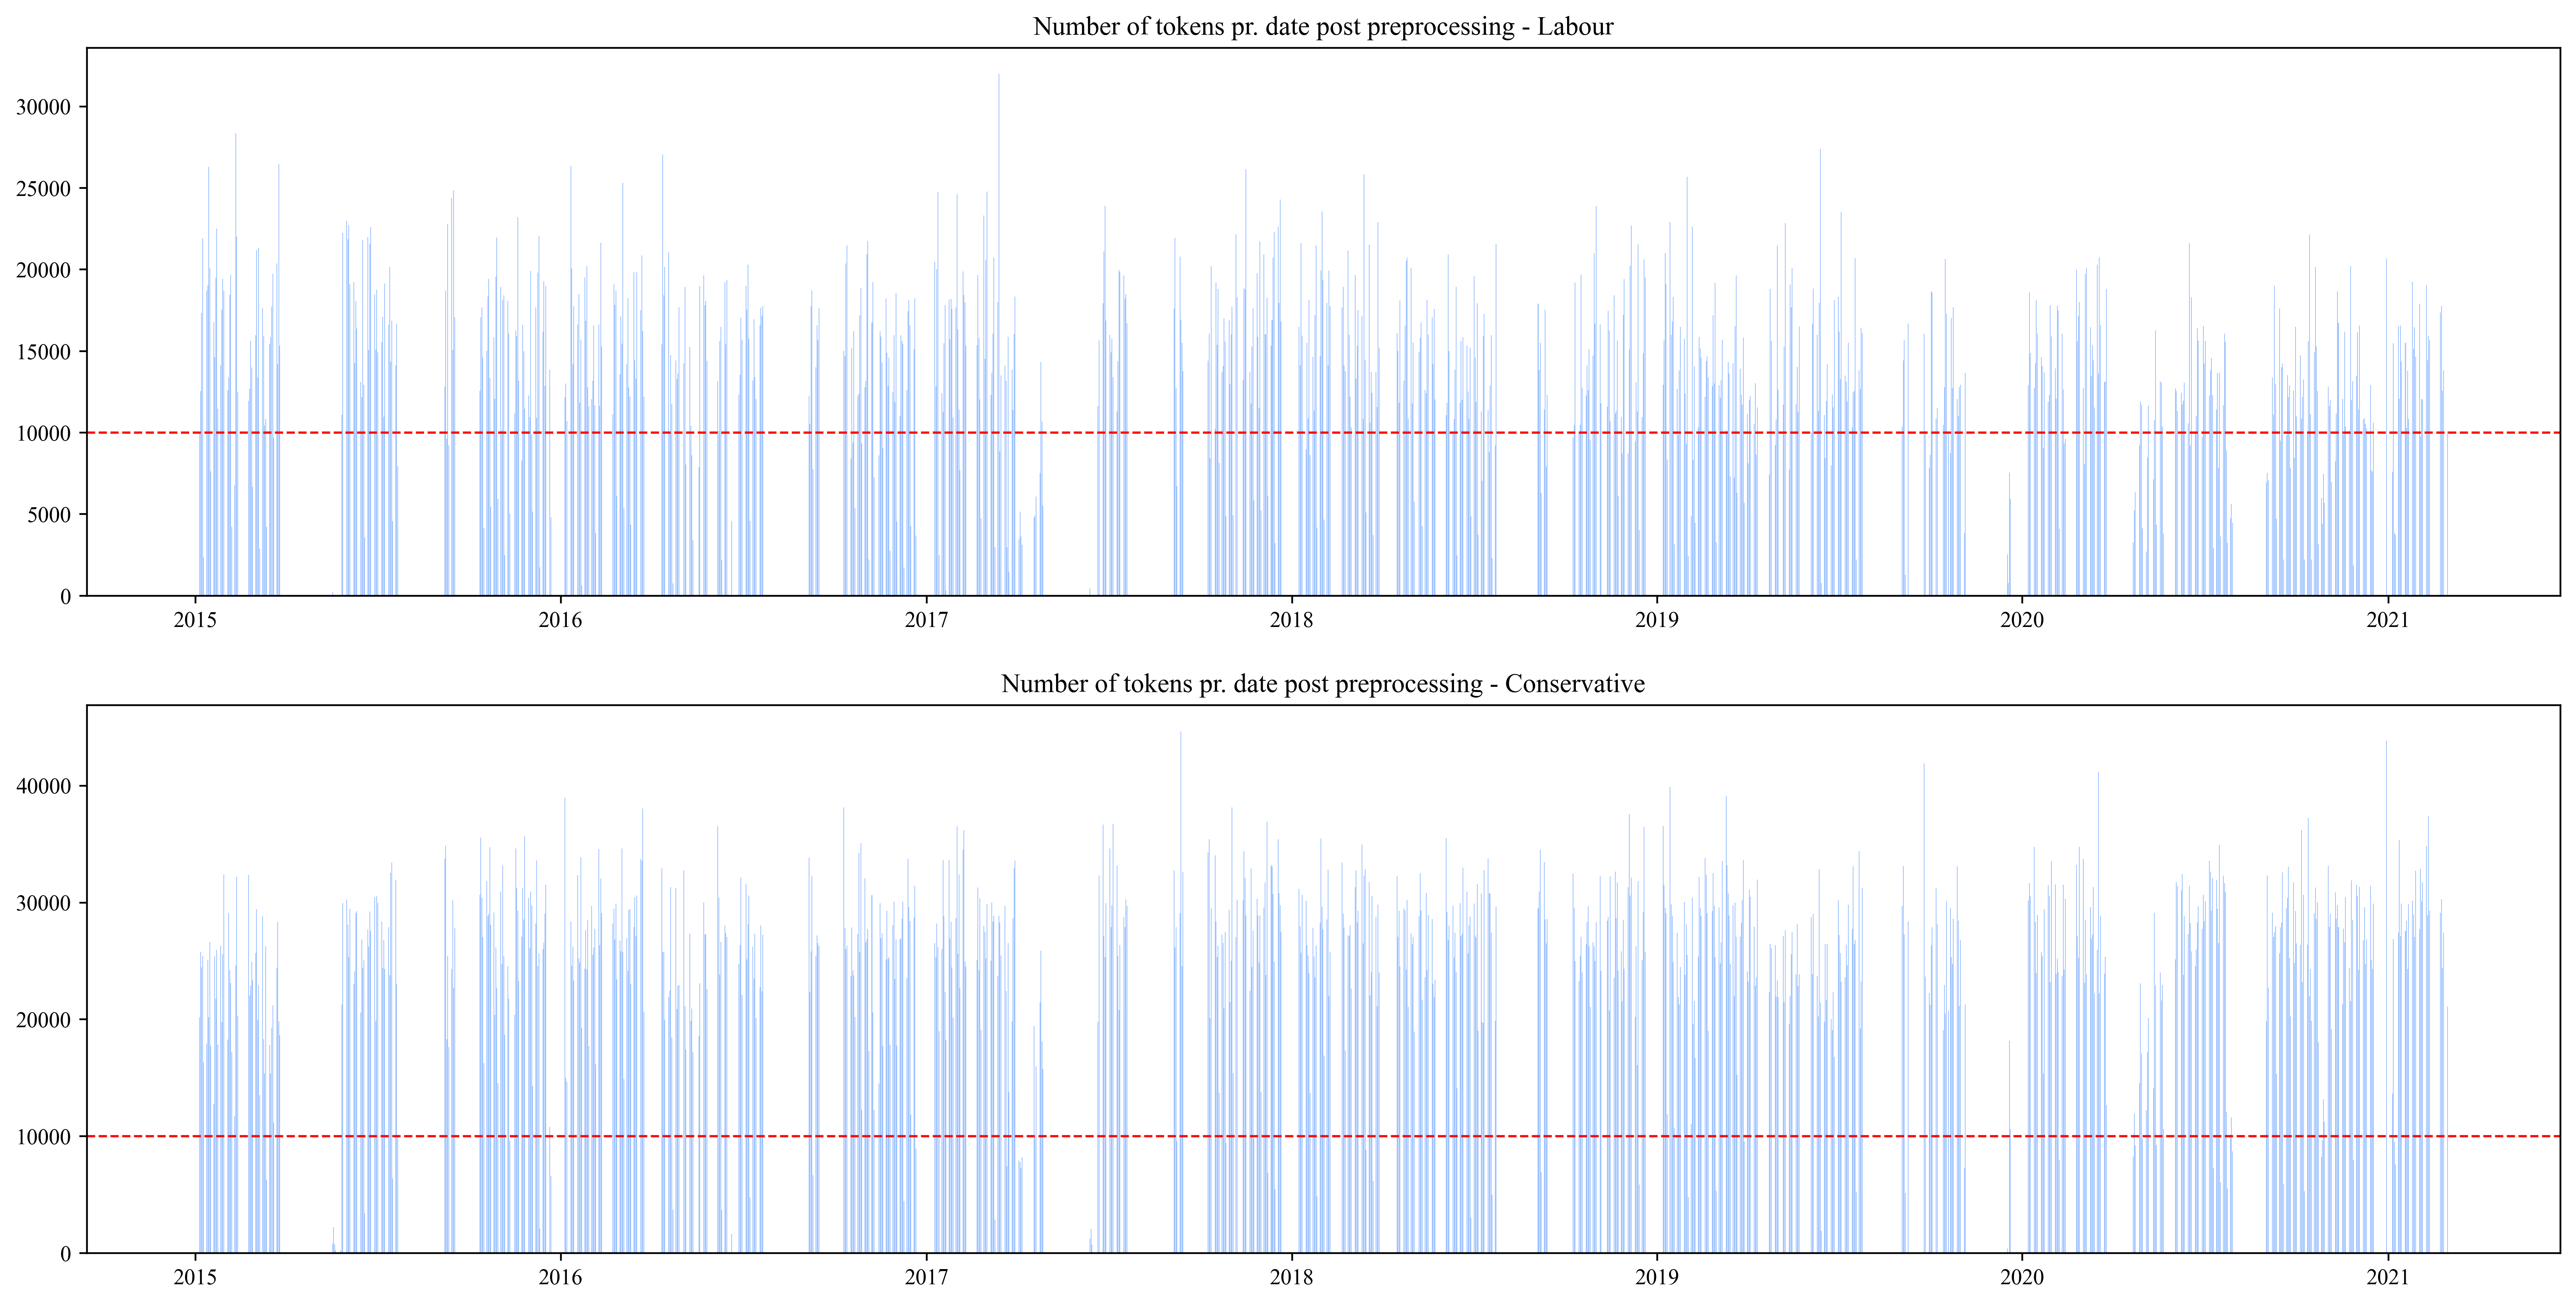

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10), dpi=1000)
ax1.bar(token_pr_date_labour.index, [len(ast.literal_eval(x)) for x in token_pr_date_labour["document"]], color = "#a0c4ff")
ax1.set_title("Number of tokens pr. date post preprocessing - Labour")
# Add some labels
ax1.axhline(10000, linestyle = "--", color = "r")

ax2.bar(token_pr_date_conservative.index, [len(ast.literal_eval(x)) for x in token_pr_date_conservative["document"]], color = "#a0c4ff")
ax2.set_title("Number of tokens pr. date post preprocessing - Conservative")
# Add some labels
ax2.axhline(10000, linestyle = "--", color = "r")

plt.show()

Since dictionary based methods need a large document size to work properly, it is seen from the above plot that especially the Labour document is on the limit of wheather the sentiment analysis yields a reliable result. With the Conservative document only a few days are below the recommended token size of 10000 words. This also reflect that over the entire period of the dataset, Conservative is the larger party.

Here some days of interest are highlighted. 

In [44]:
#Dates of note
election_days = [datetime.strptime("2015-05-07", "%Y-%m-%d").date(), datetime.strptime("2017-06-08", "%Y-%m-%d").date(), datetime.strptime("2019-12-12", "%Y-%m-%d").date()]
brexit_vote = datetime.strptime("2016-06-23", "%Y-%m-%d").date()
covid_lockdown = datetime.strptime("2020-03-23", "%Y-%m-%d").date()

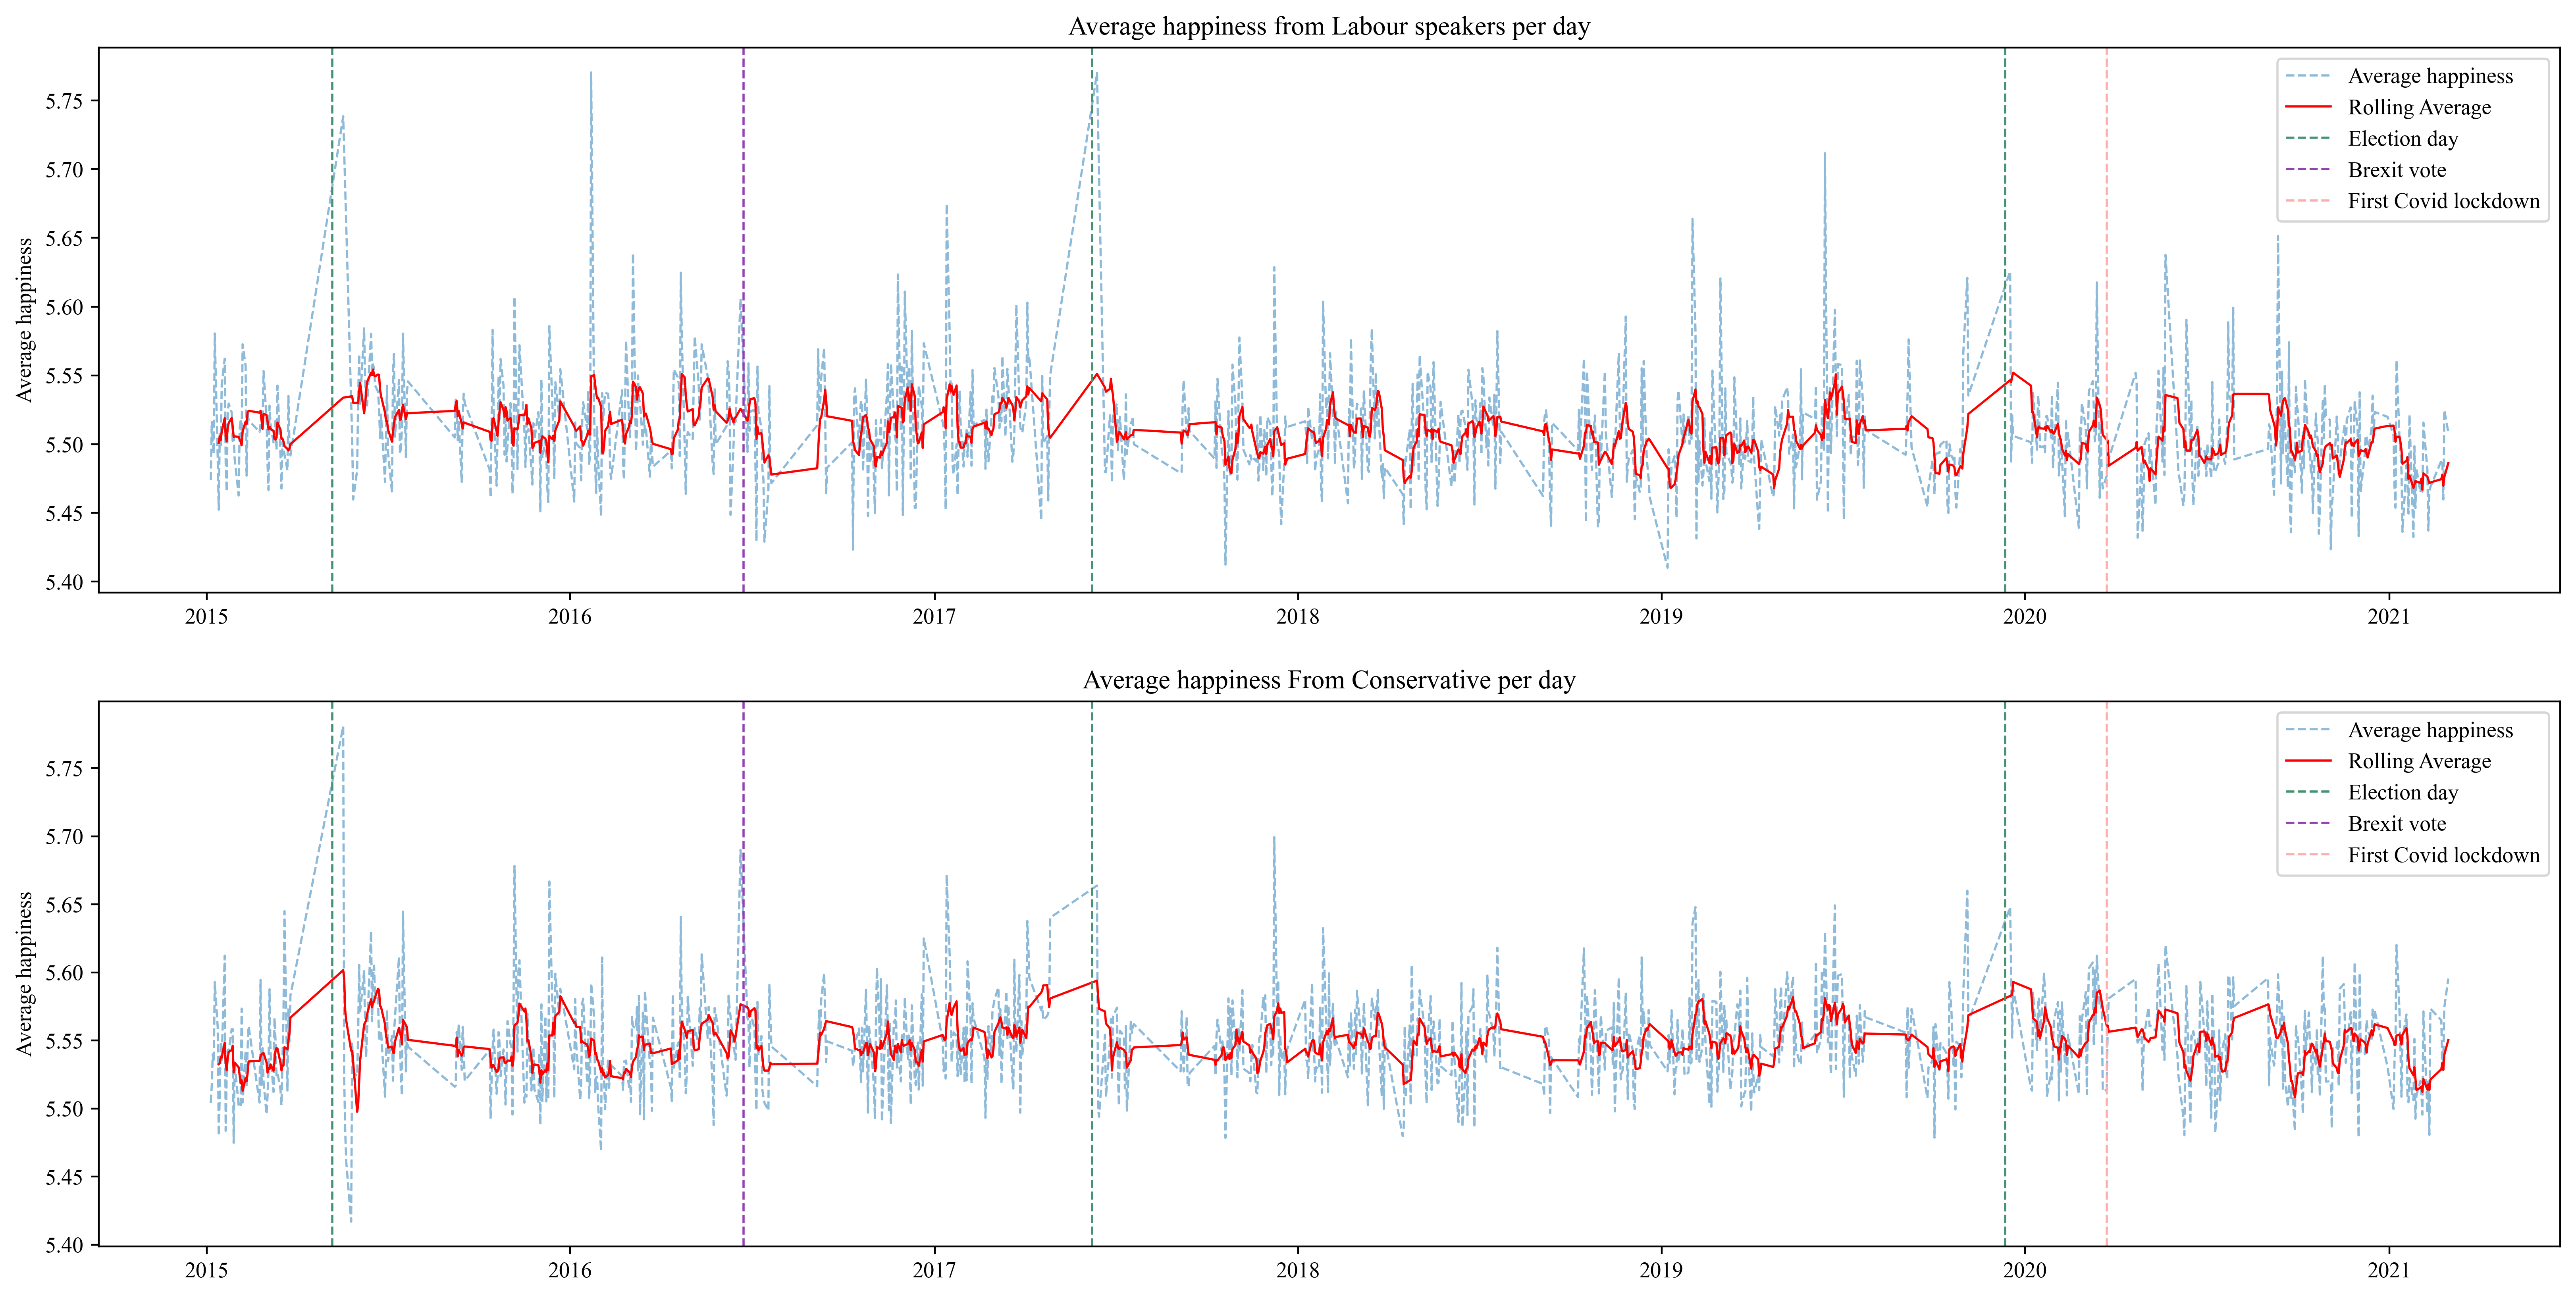

In [66]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10), dpi=400)
rolled_series = token_pr_date_labour["daily_happiness"].rolling(7).mean()
ax1.plot(token_pr_date_labour.index, token_pr_date_labour["daily_happiness"], ls = "--", alpha = 0.5, label='Average happiness')
ax1.plot(rolled_series.index, rolled_series.values, color = "r", label='Rolling Average')
for idx in range(len(election_days)):
    ax1.axvline(election_days[idx], ls = "--", color = color_list[3])
ax1.axvline(election_days[-1], label = "Election day", ls = "--", color = color_list[3])
ax1.axvline(brexit_vote, label = "Brexit vote", color = color_list[4], ls = "--")
ax1.axvline(covid_lockdown, label = "First Covid lockdown", color = color_list[9], ls = "--")
ax1.set_title("Average happiness from Labour speakers per day")
ax1.set_ylabel("Average happiness")
ax1.legend()

rolled_series2 = token_pr_date_conservative["daily_happiness"].rolling(7).mean()
ax2.plot(token_pr_date_conservative.index, token_pr_date_conservative["daily_happiness"], ls = "--", alpha = 0.5, label='Average happiness')
ax2.plot(rolled_series2.index, rolled_series2.values, color = "r", label='Rolling Average')
for idx in range(len(election_days)):
    ax2.axvline(election_days[idx], ls = "--", color = color_list[3])
ax2.axvline(election_days[-1], label = "Election day", ls = "--", color = color_list[3])
ax2.axvline(brexit_vote, label = "Brexit vote", color = color_list[4], ls = "--")
ax2.axvline(covid_lockdown, color = color_list[9], label = "First Covid lockdown", ls = "--")
ax2.set_title("Average happiness From Conservative per day")
ax2.set_ylabel("Average happiness")
ax2.legend()
fig.savefig("happiness_scores.png")
plt.show()

In [46]:
mean_labour_happiness = np.mean(token_pr_date_labour["daily_happiness"].values)
mean_conservative_happiness = np.mean(token_pr_date_conservative["daily_happiness"].values)
print(f"Mean Labour happiness score: {mean_labour_happiness}")
print(f"Mean Conservative happiness score: {mean_conservative_happiness}")

Mean Labour happiness score: 5.508579469270198
Mean Conservative happiness score: 5.5480341116436005


In [47]:
token_pr_date_labour["daily_happiness"].corr(token_pr_date_conservative["daily_happiness"])

0.5950086078205029

As seen from the plots and the mean happiness score for each party there are no great fluctuations, either overtime or between the two parties. This is mainly attributed to the text being in a highly formal setting and the words are chosen reflect that. Since most MP make use of this language, though they highly disagree on topics, it pushes the sentiment score towards the neutral 5. It is interesting, however, that the sentiment score is still above 5 in this setting, again showing support for the *Pollyanna hypothesis*.

A correlation of 0.595 between the happiness scores for each party indicates that the sentiment in the parliament follows at some level the same tendencies. This makes sense since there is a natural linkage between the topics addressed by MP in the chronological order the data is presented. Many topics of bills discussed in the house poses a problem where parties differ on which solution is most appropriate.

### Wordshifts

In the following section, the wordshifts for both the Conservative and Labour party will be explored. 

Originally this part of the analysis was intended for the Party status attribute (Coalition, Opposition), as it was hypothesised to yield a more distinctive separation of central word use related to the sentiment around certain events. Instead, two major parties were chosen.

As a major event the first COVID lockdown in UK was chosen. To create the wordshifts two lists are defined, one containing all the words say that day in a single document and a reference list that looks back in time.

In [48]:
max_h = token_pr_date_conservative["daily_happiness"].max()
date_max_h = pd.to_datetime("2020-03-23").date() # first COVID lockdown
d_max = date_max_h - timedelta(days = 14) # 7 days before as reference

In [49]:
l = ast.literal_eval(token_pr_date_labour["document"].loc[date_max_h])
l_ref = token_pr_date_labour["document"][((token_pr_date_labour.index <= date_max_h) & (token_pr_date_labour.index >= d_max))].values
l_ref = list(itertools.chain.from_iterable([ast.literal_eval(x) for x in l_ref]))

In [50]:
p = dict([(item[0], item[1]/len(l)) for item in Counter(l).items()])
p_ref = dict([(item[0], item[1]/len(l_ref)) for item in Counter(l_ref).items()])

print(f"{dict(itertools.islice(p.items(), 5))}")
print(f"\n{dict(itertools.islice(p_ref.items(), 5))}")

{'yesterday': 0.00015246226558926666, 'march': 0.00038115566397316664, 'marked': 7.623113279463333e-05, 'third': 0.0003049245311785333, 'anniversary': 0.00015246226558926666}

{'inform': 5.139439415645739e-05, 'house': 0.0035140917004477736, 'calling': 0.00017345608027804368, 'question': 0.0010600093794769336, 'leave': 0.0005974598320688171}


In [51]:
# Top 10 word used for the given day.
sorted(p.items(), key = lambda x: x[1], reverse = True)[:10]

[('government', 0.013264217106266199),
 ('people', 0.012883061442293033),
 ('hon', 0.006937033084311633),
 ('need', 0.006937033084311633),
 ('would', 0.0068608019515169994),
 ('house', 0.006479646287543833),
 ('bill', 0.0064034151547491995),
 ('right', 0.006022259490776033),
 ('minister', 0.0059460283579814),
 ('care', 0.005336179295624333)]

In [52]:
# Top 10 word used for the reference days.
sorted(p_ref.items(), key = lambda x: x[1], reverse = True)[:10]

[('government', 0.011313191013690181),
 ('people', 0.009655721802144432),
 ('would', 0.005415684284236697),
 ('minister', 0.0053899870871584685),
 ('need', 0.00536428989008024),
 ('many', 0.004683314167507179),
 ('hon', 0.004246461817177291),
 ('support', 0.004085854335438362),
 ('also', 0.0038288823646560753),
 ('one', 0.0038031851675778463)]

In [53]:
all_tokens = set(p.keys()).union(set(p_ref.keys())) # Set of the tokens that exist in both p and p_ref.
# dp show the difference between the two lists.
dp = dict([(token, p.get(token, 0) - p_ref.get(token, 0)) for token in all_tokens])
print(f"{dict(itertools.islice(dp.items(), 5))}")

{'fifteenfold': -6.4242992695571735e-06, 'dissent': -1.2848598539114347e-05, 'coventry': 1.1988140099061605e-05, 'joint': -9.080064821385317e-05, 'riverside': -6.424299269557173e-05}


In [54]:
#print top10
sorted(dp.items(), key = lambda x: x[1], reverse = True)[0:10]

[('people', 0.0032273396401486017),
 ('bill', 0.003184841220701056),
 ('measures', 0.003178074109303988),
 ('house', 0.0029655545870960593),
 ('hon', 0.0026905712671343417),
 ('right', 0.002604532279371617),
 ('staff', 0.0024637153417539012),
 ('workers', 0.0023279445986531476),
 ('must', 0.0020692517109907552),
 ('powers', 0.0020273806377365546)]

In [55]:
labMT_dict = dict(zip(labMT["Word"].values, labMT["Happiness Score"].values))
# Compute happiness for each word where all scores are shifted by -5
h = dict([(token, labMT_dict.get(token, np.nan) - 5) for token in all_tokens])

In [56]:
# Compute the product of delta p and h
dPhi = [(token, h[token] * dp[token]) for token in all_tokens if not np.isnan(h[token])]

In [57]:
# dPhi are the words that contributes most in the shifting of the happiness scores. 
sorted(dPhi, key = lambda x:np.abs(x[1]), reverse=True)[:10]

[('noble', -0.005808485276181414),
 ('women', -0.005556761896196173),
 ('bill', -0.004331384060153436),
 ('lord', -0.004070158887867544),
 ('right', 0.00401097971023229),
 ('house', 0.003973843146708719),
 ('people', 0.0037437139825723786),
 ('death', -0.003531085171858199),
 ('emergency', -0.003388856945273945),
 ('powers', 0.003365451858642681)]

C:\Users\Daniel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\shifterator\plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


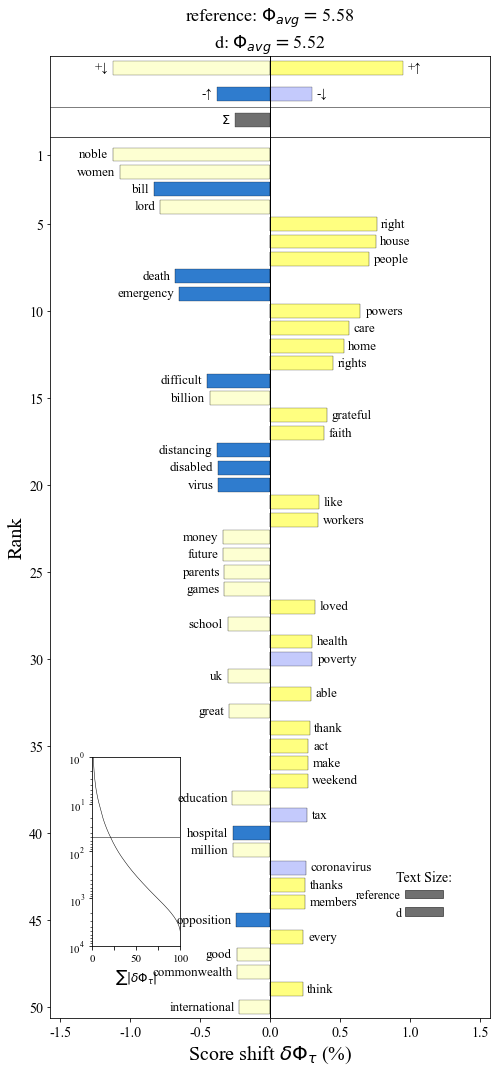

<AxesSubplot:title={'center':'reference: $\\Phi_{avg}=$5.58\nd: $\\Phi_{avg}=$5.52'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [58]:
sentiment_sh = sh.WeightedAvgShift(type2freq_1 = p_ref, type2freq_2 = p, type2score_1 = labMT_dict, reference_value = 5)
sentiment_sh.get_shift_graph(detailed = True, system_names = ["reference", "d"])

Now the same procedure is used for the Conservative Party.

In [59]:
# For the Conservative party
l = ast.literal_eval(token_pr_date_conservative["document"].loc[date_max_h])
l_ref = token_pr_date_conservative["document"][((token_pr_date_conservative.index <= date_max_h) & (token_pr_date_conservative.index >= d_max))].values
l_ref = list(itertools.chain.from_iterable([ast.literal_eval(x) for x in l_ref]))
p = dict([(item[0], item[1]/len(l)) for item in Counter(l).items()])
p_ref = dict([(item[0], item[1]/len(l_ref)) for item in Counter(l_ref).items()])

print(f"{dict(itertools.islice(p.items(), 5))}")
print(f"\n{dict(itertools.islice(p_ref.items(), 5))}")

{'plans': 0.000250857095074839, 'mark': 8.361903169161301e-05, 'conclusion': 0.0007525712852245171, 'initial': 4.1809515845806506e-05, 'term': 0.00016723806338322602}

{'recent': 0.0003900756174109715, 'assessment': 0.0001717764186763911, 'made': 0.0029309351436659233, 'trends': 2.147205233454889e-05, 'number': 0.0015996678989238923}


In [60]:
# Top 10 word used for the given day.
sorted(p.items(), key = lambda x: x[1], reverse = True)[:10]

[('hon', 0.010786855088218078),
 ('government', 0.01015971235053098),
 ('right', 0.008403712685007107),
 ('bill', 0.0076093318839367844),
 ('house', 0.006480474956100008),
 ('people', 0.006313236892716782),
 ('friend', 0.005811522702567104),
 ('need', 0.005644284639183878),
 ('would', 0.005226189480725813),
 ('new', 0.004766284806421941)]

In [61]:
# Top 10 word used for the reference days.
sorted(p_ref.items(), key = lambda x: x[1], reverse = True)[:10]

[('hon', 0.009283083959303303),
 ('government', 0.0077299388404376),
 ('people', 0.007035675814953853),
 ('right', 0.006577605365150143),
 ('friend', 0.006380778218750112),
 ('noble', 0.00541095718830632),
 ('would', 0.004795425021382586),
 ('support', 0.004437557482473437),
 ('also', 0.0041369487497897525),
 ('need', 0.004029588488117008)]

In [62]:
all_tokens = set(p.keys()).union(set(p_ref.keys())) # Set of the tokens that exist in both p and p_ref.
# dp show the difference between the two lists.
dp = dict([(token, p.get(token, 0) - p_ref.get(token, 0)) for token in all_tokens])
print(f"{dict(itertools.islice(dp.items(), 5))}")
labMT_dict = dict(zip(labMT["Word"].values, labMT["Happiness Score"].values))
# Compute happiness for each word where all scores are shifted by -5
h = dict([(token, labMT_dict.get(token, np.nan) - 5) for token in all_tokens])
# Compute the product of delta p and h
dPhi = [(token, h[token] * dp[token]) for token in all_tokens if not np.isnan(h[token])]
# dPhi are the words that contributes most in the shifting of the happiness scores. 
sorted(dPhi, key = lambda x:np.abs(x[1]), reverse=True)[:10]

{'dissent': 3.4652165067623544e-05, 'coventry': 1.3180112733074651e-05, 'joint': 1.2220432829001035e-05, 'swiss': -7.157350778182964e-06, 'cowardly': -7.157350778182964e-06}


[('bill', -0.00628474759030174),
 ('noble', -0.005972010538499086),
 ('powers', 0.005361482445431507),
 ('coronavirus', -0.004195842758404184),
 ('care', 0.004154860308883938),
 ('health', 0.003995995253665583),
 ('women', -0.003841321991691592),
 ('house', 0.003413664342674549),
 ('act', 0.0033513985299882974),
 ('lord', -0.0029912874048966752)]

C:\Users\Daniel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\shifterator\plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


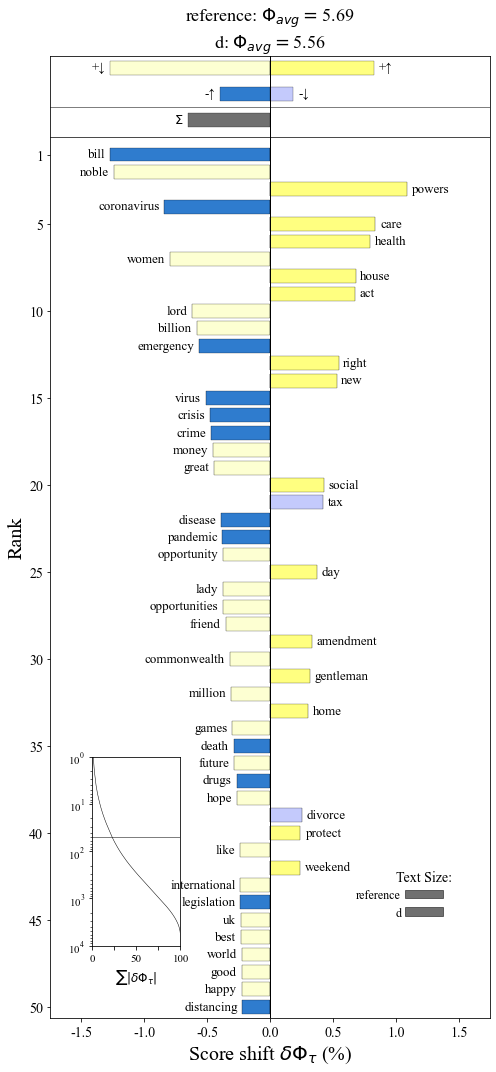

<AxesSubplot:title={'center':'reference: $\\Phi_{avg}=$5.69\nd: $\\Phi_{avg}=$5.56'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [63]:
sentiment_sh = sh.WeightedAvgShift(type2freq_1 = p_ref, type2freq_2 = p, type2score_1 = labMT_dict, reference_value = 5)
sentiment_sh.get_shift_graph(detailed = True, system_names = ["reference", "d"])

Here it is seen that both parties are slightly down in happiness scores compared with the 14 days before it is referenced against. But what is interesting is perhaps not the score itself, but the change in word frequency that their wordshifts uncovers. 

For negative words that emerge more than the usual, bill is at the top for both parties. This is a natural finding as legislators are proposing and discussing bills that can relieve the situation. Another series of negative words that are up are words describing the consequences of the pandemic, like "death", "emergency", "distancing", "crisis" etc.  

The positive words (right side of the figure) tell how the politicians for the respective parties address this time of crisis and how they wish to inspire hope and unity in the population. 

### TF-IDF
The following section will make use of the text mining tool TF-IDF to try and distinguish important topics within different parties e.g. Liberals and Conservatives. Among other cool stuff that we will figure out on the fly.

First of all a new preprocess of the data is made, that in addition to remove stopwords also stems the tokens.

##### Data Fetch

In [2]:
#define topic list
topic_list = ['education', 'health', 'eu', 'immigration', 'crime',
             'pandemic', 'vaccine', 'world', 'environment',
             'economy', 'legislation', 'employment', 'transport', 'tax', 'pension', 'welfare', 'defence','test']
porter = nltk.PorterStemmer()
topic_list = [porter.stem(x) for x in topic_list]

In [ ]:
def preprocess(text):
    #Common english stop words
    stop_words = set(stopwords.words('english'))
    #Tokenize using nltk
    word_tokens = word_tokenize(text.lower())
    #removing none letter characters and stop words
    filtered_sentence = [w for w in word_tokens if w not in stop_words and w.isalpha()]
    #Conduct stemming
    processed_text = [porter.stem(t) for t in filtered_sentence]
    return processed_text
    
ParlaMint['tokens'] = [preprocess(x) for x in ParlaMint['Text']] 

In [ ]:
# Save data to avoid multiple preprocesses
ParlaMint.to_csv('parlamint_preprocess.csv')

In [7]:
# Read data if preprocessed before
ParlaMint = pd.read_csv("data/parlamint_preprocess.csv")
ParlaMint.head()

Unnamed: 0                                  ID  \
0           0  ParlaMint-GB_2015-01-05-commons.u1   
1           1  ParlaMint-GB_2015-01-05-commons.u2   
2           2  ParlaMint-GB_2015-01-05-commons.u3   
3           3  ParlaMint-GB_2015-01-05-commons.u4   
4           4  ParlaMint-GB_2015-01-05-commons.u5   

                                               Title        From          To  \
0  Minutes of the House of Commons, Daily Session...  2015-01-05  2015-01-05   
1  Minutes of the House of Commons, Daily Session...  2015-01-05  2015-01-05   
2  Minutes of the House of Commons, Daily Session...  2015-01-05  2015-01-05   
3  Minutes of the House of Commons, Daily Session...  2015-01-05  2015-01-05   
4  Minutes of the House of Commons, Daily Session...  2015-01-05  2015-01-05   

         House  Term  Subcorpus Speaker_role Speaker_type Speaker_party  \
0  Lower house    55  Reference      Regular           MP            LD   
1  Lower house    55  Reference      Regular           MP           CON   
2  Lower house    55  Reference      Regular           MP            LD   
3  Lower house    55  Reference      Regular           MP           CON   
4  Lower house    55  Reference      Regular           MP           LAB   

  Speaker_party_name Party_status             Speaker_name Speaker_gender  \
0   Liberal Democrat    Coalition  Willott, Jennifer Nancy              F   
1       Conservative    Coalition        May, Theresa Mary              F   
2   Liberal Democrat    Coalition  Willott, Jennifer Nancy              F   
3       Conservative    Coalition        May, Theresa Mary              F   
4             Labour   Opposition    Cunningham, Alexander              M   

  Speaker_birth                                               Text  \
0             -  1. What progress her Department has made on im...   
1             -  The Government are on track to deliver their c...   
2             -  It is clear that exit checks, which were scrap...   
3             -  As I indicated in my original answer, we are o...   
4             -  19. Given the situation at our border in Calai...   

                                              tokens  
0  ['progress', 'depart', 'made', 'implement', 'e...  
1  ['govern', 'track', 'deliv', 'commit', 'introd...  
2  ['clear', 'exit', 'check', 'scrap', 'previou',...  
3  ['indic', 'origin', 'answer', 'track', 'ensur'...  
4  ['given', 'situat', 'border', 'calai', 'home',...

In [8]:
# Convert tokens to list
ParlaMint['tokens'] = ParlaMint['tokens'].apply(lambda x: ast.literal_eval(x)) 

##### Data manipulations
Each observation in the dataframe consist of a specific speach associated with metadata e.g. speaker name, speaker party etc. Initially, we will create one document for each party by concatenating all of the speaches conducted by the members of the same parties. This would yield a corpus consisting of:

In [9]:
print(f'Number of documents in the corpus: {len(ParlaMint.Speaker_party_name.unique())}')

Number of documents in the corpus: 48


In [10]:
corpus_sklearn = []
stopwords = ['hon', 'nobl', 'baro', 'uk']
parties = ParlaMint.Speaker_party_name.dropna().unique()
for party in tqdm(parties):
    temp = ParlaMint[ParlaMint['Speaker_party_name']==party]
    doc = [x for sublist in temp['tokens'] for x in sublist if x not in stopwords]
    corpus_sklearn.append(doc)

100%|██████████| 47/47 [00:06<00:00,  7.53it/s]


Now we have a document for each party and a combined corpus of 37 documents. The next step is to compute the tf-idf weightings of all terms in the corpus. 

In [11]:
def TFIDF(corpus: list, min_df=0, max_df=1) -> DataFrame:
    '''
    corpus: A list of lists containing tokenized documents
    min_df: Threshold for removal of non-frequent words
    max_df: Threshold for removal of very frequent words

    The following function calculates and outputs the TF-IDF weighted term-document matrix.
    Notice that the IDF formulation used in this function deviates from the standard text book formula:
     * Adding 1 to the IDF ensures that terms with zero idf e.g. terms occuring in all documents are not completly ignored.
     * Hence, using idf(t) = log [ n / df(t) ] + 1 instead of idf(t) = log [ n / (df(t) + 1) ]).
    Furthermore, the IDF is also smoothened to avoid division by zero, by essentially pretendind that an extra document is added containing all terms to avoid division by zero:
     * idf(t) = log [ (n+1) / df(t+1) ] + 1
    '''
    N = len(corpus)

    if min_df != 0 or max_df != 1:
        term_set = set([x for sublist in corpus for x in sublist])
        doc_freq = dict.fromkeys(term_set, 0)
        for term in term_set:
            for doc in corpus:
                if term in doc:
                    doc_freq[term] += 1
        doc_freq = {key: value/N for (key, value) in doc_freq.items()}
        term_set = set([term for (term, value) in doc_freq.items() if value < max_df and value > min_df])
    else:
        term_set = set([x for sublist in corpus for x in sublist])

    idf_dict = dict.fromkeys(term_set, 0)
    tfidf_dicts = [None] * N
    tf_dicts = [None] * N
    idx = 0
    for doc in corpus:
        tf_dict = dict.fromkeys(term_set, 0)
        tf_dict.update({key: value/len(doc) for (key, value) in dict(FreqDist(doc)).items() if key in term_set}) #Normalized frequencies
        tf_dicts[idx] = tf_dict
        for (term, freq) in tf_dict.items():
            if freq > 0:
                idf_dict[term] += 1
        idx += 1

    idf_dict = {term: np.log( (N + 1) / (float(value) + 1)) + 1 for (term, value) in idf_dict.items()}
    for i in range(N):
        tf_dict = tf_dicts[i]
        temp = {term: tf_dict[term] * idf_dict[term] for term in term_set}
        tfidf_dicts[i] = {term: value / (np.sqrt(sum([x**2 for x in list(temp.values())]))) for (term, value) in temp.items()} #Converting to unit norm with l2

    return pd.DataFrame(tfidf_dicts)

Due to the amount of data this implementation is very time consuming. Therefore, the rest of the analysis will make use of Sklearns vectorized TF-IDF implmentation. However, we will first demonstrate that the two implementations yield the same results. 

In [12]:
TDM = TFIDF(corpus_sklearn[:3], max_df = 0.7, min_df = 0.05)
TDM

In [ ]:
def dummy_fun(doc):
    return doc
vectorizer = TfidfVectorizer(min_df=5, max_df = 0.7, analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)
vecs = vectorizer.fit_transform(corpus_sklearn[:3])
feature_names = vectorizer.get_feature_names()
dense = vecs.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names).dropna()
df.index = parties
df

### Party similarity (TF-IDF & Cosine similarity)
Once the term-document matrix with TF-IDF weighting have been determined, the cosine similarity between each document can be used to determine similarity between documents, and thereby between parties.

Non-suprisingly, the term frequencies does not provide a lot of usefull insights as a description of the documents. Subsequently, the TF-IDF will be computed for each of the chosen five documents:

In [ ]:
subset_parties = ['Liberal Democrat', 'Conservative', 'Labour', 'Scottish National Party', 'UK Independence Party']

In [ ]:
term_doc_matrix = df.loc[subset_parties].to_numpy()
term_doc_matrix

Given that sklearns TFIDF vectorizer already normalizes the cosine similarity can simply determined as follows:

In [ ]:
sim_matrix = (term_doc_matrix @ term_doc_matrix.T)

Lets depict the similarity matrix using a heatmap:

In [ ]:
import seaborn as sns; sns.set_theme()
fig, ax = plt.subplots(dpi=200)
sns.heatmap(sim_matrix, xticklabels=subset_parties ,yticklabels=subset_parties, cmap="YlGnBu")
plt.tight_layout()
plt.savefig('Party_similarity.pdf', dpi=200)

### Bubble plots- lexical dispersion plots

The following section will display lexical dispersion plots of the topics in the British Parliament with a unique style.

### Discussion

##### What went well?

##### What is still missing? What could be improved?, Why?